In [1]:
#####################################################################
#In this notebook we explore different community detection algorithms: 
#Walktrap, spinglass, Infomap, label propagation, 
#Louvian: modularity, RB, RBER, CPM, Surprise
#
#We compare the outcome for the different algorithms
#####################################################################

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import louvain
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd

C:\Users\hilar\AppData\Local\Temp\ipykernel_28108\111947014.py:5: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [3]:
def graph_generation(directory,year, commodity):
    '''This function upload the csv with the data in "directory" 
    and return a networkx graph for a specific year and commodity.'''
    
    fields = ['yr','rt3ISO','pt3ISO','cmdCode','TradeValue']
    df = pd.read_csv(directory, skipinitialspace = True, usecols = fields)
    #Filter by commodity and year
    df = df[df['yr']      == year]
    df = df[df['cmdCode'] == commodity]
    
    G = nx.from_pandas_edgelist(df,
                             source       = 'rt3ISO',
                             target       = 'pt3ISO',
                             edge_attr    =  'TradeValue',
                             create_using = nx.DiGraph())
    print(nx.info(G))
    return(G)

# Community detection

In [4]:
def Community_save(Graph, communities, filename,year,commodity, plot=False, print_communities=False):
    '''This function save the different communities found by any of the algorithms that we tested
    for this project. 
    The inputs arem the graph to use,'''
    membership = communities.membership
    df = pd.DataFrame()
    df['Node'] = Graph.vs['_nx_name']
    df['Community'] = membership
    df = df.sort_values('Community')
    df.to_csv(f"Data/Community/{filename}_{year}_{commodity}_communities.csv", index=False)
    
    if plot:
        ax = df.hist(column='Community', bins = np.max(df['Community']+1),  grid=False, figsize=(12,8), color='blue', zorder=1, rwidth=0.9)

        ax = ax[0]
        for x in ax:

            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Remove title
            x.set_title("")

            # Set x-axis label
            x.set_xlabel("Community class", labelpad=20, weight='bold', size=15)

            # Set y-axis label
            x.set_ylabel("Size", labelpad=20, weight='bold', size=15)
    
            x.set_title("Communities using "+filename+" algoritm ",  size=20)


## Walktrap
https://towardsdatascience.com/detecting-communities-in-a-language-co-occurrence-network-f6d9dfc70bab

In [5]:
def walktrap(g):
    wtrap_clust = g.community_walktrap(steps = 4, weights= g.es['TradeValue'] )
    wtrap_clust=wtrap_clust.as_clustering()
    wtrap_mod = wtrap_clust.modularity
    wtrap_n   = np.max(wtrap_clust.membership)
    #print("modularity:", wtrap_mod)   
    return(wtrap_clust,wtrap_mod,wtrap_n)

## Spinglass

In [6]:
def spinglass(g):
    #Notice that for spinglass we have to operate over the giant component
    #The algorithm doesnt work if a piece is disconnected

    largest = g.clusters().giant()
    #print("Largest component size:",len(largest.vs))
    
    spinglass=largest.community_spinglass()
    spinglass_mod = spinglass.modularity
    spinglass_n   = np.max(spinglass.membership)
    #print("modularity:", spinglass_mod)
    
    return(largest,spinglass, spinglass_mod,spinglass_n)



## Infomap

In [7]:
def infomap(g):
    info_clust=g.community_infomap( edge_weights= g.es['TradeValue'])
    infomap_n   = np.max(info_clust.membership)
    infomap_mod = info_clust.modularity
    #print("modularity:", infomap_mod)
    
    return(info_clust,infomap_mod,infomap_n)

## Label propagation

In [8]:
def label_propagation(g):
    label_clust=g.community_label_propagation( weights= g.es['TradeValue'])
    label_propagation_n   = np.max(label_clust.membership)+1
    label_propagation_mod = label_clust.modularity
    #print("modularity:", label_propagation_mod)
    return(label_clust,label_propagation_mod,label_propagation_n)


## Louvian

https://louvain-igraph.readthedocs.io/en/latest/reference.html

In [9]:
def louvian_modularity(g):
    #Modularity
    louvian_clust = louvain.find_partition(g, louvain.ModularityVertexPartition, weights="TradeValue")
    louvian_n     = np.max(louvian_clust.membership)+1
    lc_mod = louvian_clust.modularity
    #print("modularity:", lc_mod)
    return(louvian_clust, lc_mod,louvian_n)


In [10]:
def louvian_RB(g):
    #RB
    louvian_clust_RB = louvain.find_partition(g, louvain.RBConfigurationVertexPartition, weights="TradeValue")
    louvianRB_n      = np.max(louvian_clust_RB.membership)+1
    lRB_mod = louvian_clust_RB.modularity
    #print("modularity:", lRB_mod)
    return(louvian_clust_RB,lRB_mod,louvianRB_n)


In [11]:
def louvian_RBER(g):
    #RBER
    louvian_clust_RBER = louvain.find_partition(g, louvain.RBERVertexPartition, weights="TradeValue")
    louvianRBER_n      = np.max(louvian_clust_RBER.membership)+1
    lRBER_mod = louvian_clust_RBER.modularity
    #print("modularity:", lRBER_mod)
    return(louvian_clust_RBER,lRBER_mod,louvianRBER_n)


In [12]:
def louvian_CPM(g):
    #CPM
    louvian_clust_CPM = louvain.find_partition(g, louvain.CPMVertexPartition, weights="TradeValue")
    louvianCPM_n      = np.max(louvian_clust_CPM.membership)+1
    lCPM_mod = louvian_clust_CPM.modularity
    #print("modularity:", lCPM_mod)
    return(louvian_clust_CPM,lCPM_mod,louvianCPM_n)


In [13]:
def louvian_surp(g):
    #Surprise
    louvian_clust_surp = louvain.find_partition(g, louvain.SurpriseVertexPartition, weights="TradeValue")
    louvian_surp_n      = np.max(louvian_clust_surp.membership)+1
    lsurp_mod = louvian_clust_surp.modularity
    #print("modularity:", lsurp_mod)
    return(louvian_clust_surp,lsurp_mod,louvian_surp_n)


# Community estimation by year, by commodity and algorithm
## Yes it will take an ethernity

In [14]:
#Define dataframe to save information
col_names = ['Year', 'Commodity','Algorithm', 'Modularity', 'Number of communities']
df_communities_algorithms = pd.DataFrame(columns= col_names)

x_pos = [1,2,3,4,5,6]
t_label = ["Walktrap", "Spinglass","Infomap","Label Propagation","Louvian Modularity","Louvian Surprise"]

i = 0
directory = r"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/NS_FP_DATA/final_dataset.csv"
years = [i for i in range(2001,2021)]
#############################################################
###########################################################
#I just comment this lines to avoid running it acccidentally
#for year in years:
#    for commodity in range(1,24):
    
        print(commodity)
        G = graph_generation(directory,year, commodity)
        #Convert to igraph graph
        g = ig.Graph.from_networkx(G)
    
    
        wtrap_clust,wtrap_mod,wtrap_n = walktrap(g)
        df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Walktrap", 'Modularity': wtrap_mod,'Number of communities':wtrap_n}, ignore_index = True)
        Community_save(g, wtrap_clust, "Walktrap",year,commodity)
    
        largest,spinglass_clust,spinglass_mod,spinglass_n = spinglass(g)
        df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Spinglass", 'Modularity': spinglass_mod,'Number of communities':spinglass_n}, ignore_index = True)
        Community_save(largest, spinglass_clust, "Spinglass",year,commodity)

        info_clust,infomap_mod,infomap_n = infomap(g)
        df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Infomap", 'Modularity': infomap_mod,'Number of communities':infomap_n}, ignore_index = True)
        Community_save(g, info_clust, "Infomap",year,commodity )

        label_clust, label_propagation_mod,label_propagation_n = label_propagation(g)
        df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Label Propagation", 'Modularity': label_propagation_mod,'Number of communities':label_propagation_n}, ignore_index = True)
        Community_save(g, label_clust, "Label_Propagation",year,commodity)

        louvian_clust, lc_mod, lc_n = louvian_modularity(g)
        df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Louvian Modularity", 'Modularity': lc_mod,'Number of communities':lc_n}, ignore_index = True)
        Community_save(g, louvian_clust, "Louvian_Modularity",year,commodity)

#         louvian_clust_RB, lRB_mod,lRB_n = louvian_RB(g)
#         df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Louvian RB", 'Modularity': lRB_mod,'Number of communities':lRB_n}, ignore_index = True)
#         Community_save(g, louvian_clust_RB, "Louvian_RB",year,commodity)

#         louvian_clust_RBER,lRBER_mod,lRBER_n = louvian_RBER(g)
#         df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Louvian RBER", 'Modularity': lRBER_mod,'Number of communities':lRBER_n}, ignore_index = True)
#         Community_save(g, louvian_clust_RBER, "Louvian_RBER",year,commodity)

#         louvian_clust_CPM,lCPM_mod,lCPM_n = louvian_CPM(g)
#         df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Louvian CPM", 'Modularity': lCPM_mod,'Number of communities':lCPM_n}, ignore_index = True)
#         Community_save(g, louvian_clust_CPM, "Louvian_CPM",year,commodity)

        louvian_clust_surp,lsurp_mod,lsurp_n = louvian_surp(g)
        df_communities_algorithms = df_communities_algorithms.append({'Year': year, 'Commodity': commodity,'Algorithm':"Louvian Surprise", 'Modularity': lsurp_mod,'Number of communities':lsurp_n}, ignore_index = True)
        Community_save(g, louvian_clust_surp, "Louvian_Surprise",year,commodity)


IndentationError: unexpected indent (3971242958.py, line 17)

In [15]:
#Write the results to a file
#df_communities_algorithms.to_csv("Data/Community/community_algorithms_2001_2020.csv")

# Analysis

In [16]:
#Read the written file
df_communities_algorithms = pd.read_csv(r"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/Hilario/Data/Community/community_algorithms_2001_2020.csv")

In [17]:
year = 2015
commodity = 1

### Plot modularity

C:\Users\hilar\AppData\Local\Temp\ipykernel_28108\555365229.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df_communities_algorithms[df_communities_algorithms["Year"]==year][df_communities_algorithms["Commodity"]==commodity]


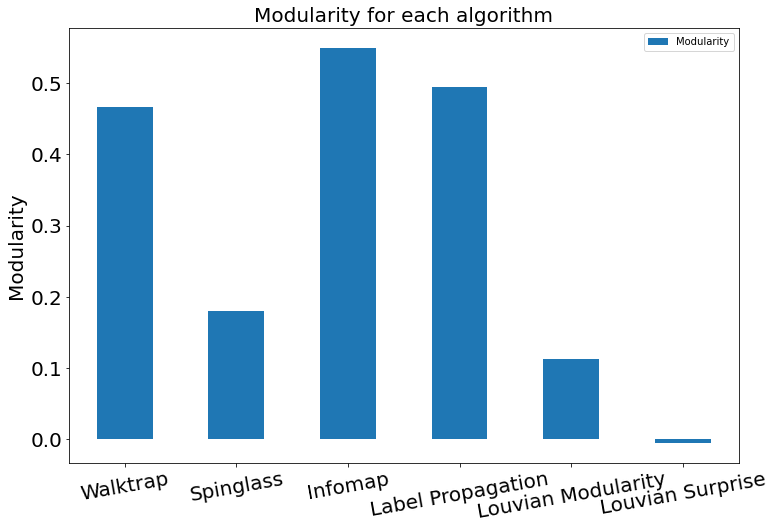

In [18]:
df_test = df_communities_algorithms[df_communities_algorithms["Year"]==year][df_communities_algorithms["Commodity"]==commodity]
df_test[["Modularity","Algorithm"]].set_index('Algorithm').plot(figsize=(12,8),kind="bar",xlabel="")

plt.title("Modularity for each algorithm",fontsize=20)
plt.ylabel("Modularity",fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation=10)
#plt.savefig('Figures/Modularity_by_algorithm.png')
plt.show()

C:\Users\hilar\AppData\Local\Temp\ipykernel_28108\4171217290.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df_communities_algorithms[df_communities_algorithms["Year"]==year][df_communities_algorithms["Commodity"]==commodity]


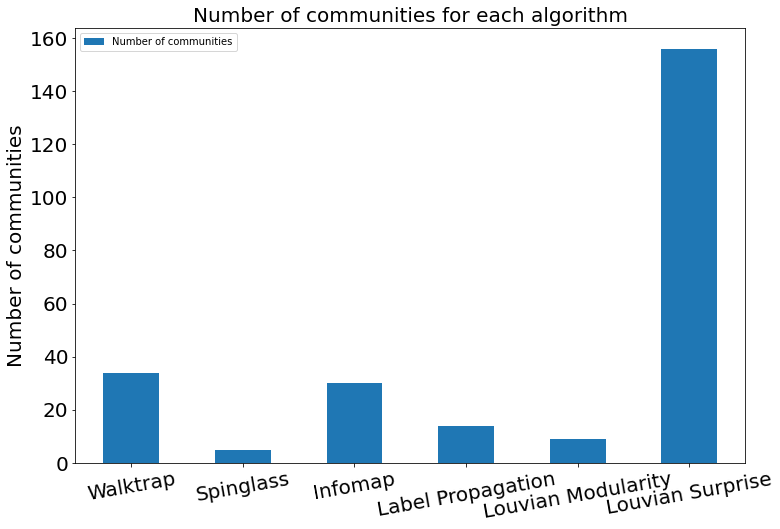

In [19]:
df_test = df_communities_algorithms[df_communities_algorithms["Year"]==year][df_communities_algorithms["Commodity"]==commodity]
df_test[["Number of communities","Algorithm"]].set_index('Algorithm').plot(figsize=(12,8),kind="bar",xlabel="")

plt.title("Number of communities for each algorithm",fontsize=20)
plt.ylabel("Number of communities",fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20,rotation=10)
#plt.savefig('Figures/communities_size_by_algorithm_bar.png')
plt.show()

# Plot the bigger communities by algorithm

In [20]:
def country_coordinates(path):
    '''Here we get the country coordinates to be used for plotting purpose'''
    c_fields     = ["cc3","latitude","longitude"]
    df_coor = pd.read_csv(path, skipinitialspace = True, usecols = c_fields)
    df_coor = df_coor.rename(columns={"cc3": "Node"})
    return(df_coor)

In [21]:
def get_all_comm2(year,commodity):
    '''This function get the communities obtained for 
       a specific     year
       and a specific commodity
       for all the algorithms Waltrap, infomap,
       label_propagation, spinglass, Louvian_Modularity, Louvian_surprise'''
    
    '''Be aware that spinglass is applied only to the giant component'''
    df = country_coordinates(r"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/NS_FP_DATA/countries.csv")
    algorithms = ["Walktrap","Infomap","Label_Propagation","Spinglass","Louvian_Modularity","Louvian_Surprise"]
    i = 3
    for algorithm in algorithms:
        df_read = pd.read_csv(fr"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/Hilario/Data/Community/{algorithm}_{year}_{commodity}_communities.csv") 
        df = pd.merge(df, df_read, on='Node', how='outer')
        df = df.rename(columns={df.columns[i]: algorithm})
        i +=1
    df = df.dropna(subset=algorithms, how='all')
    return(df)

In [22]:
def community_maps_algorithm(df,n=5):
    fig, axs = plt.subplots(3,2, figsize=(14, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    algorithms = ["Walktrap","Infomap","Label_Propagation","Spinglass","Louvian_Modularity","Louvian_Surprise"]
    #year = [i for i in range(2001,2021)]
    for i in range(len(algorithms)): 
        col= ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

        #This is a list with the code for the biggest communities in order
        biggest_communities = list(world[algorithms[i]].value_counts().to_dict().keys())
        key = biggest_communities[0:n]
        values = col[0:n]
        colors = dict(zip(key, values))
        
        
        country = []
        for j in df[algorithms[i]]:
            if math.isnan(j)==False:
                if j in key:
                    country.append(colors[j])
                else:
                    country.append('grey')
            else:
                country.append('grey')
        df.plot(ax=axs[i], color = country)
        axs[i].set_title(f'Algorithm: {algorithms[i]}')
        axs[i].set_title(f'{algorithms[i]} dettected {len(df[algorithms[i]].unique())-1} communities')
        #axs[i].set_ylabel("Latitude")
        #axs[i].set_xlabel("Longitude")
        axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])
    #    axs[i].grid(True)
    plt.tight_layout()
    #plt.savefig('Figures/communities_by_algorithm.png')
    plt.show()  

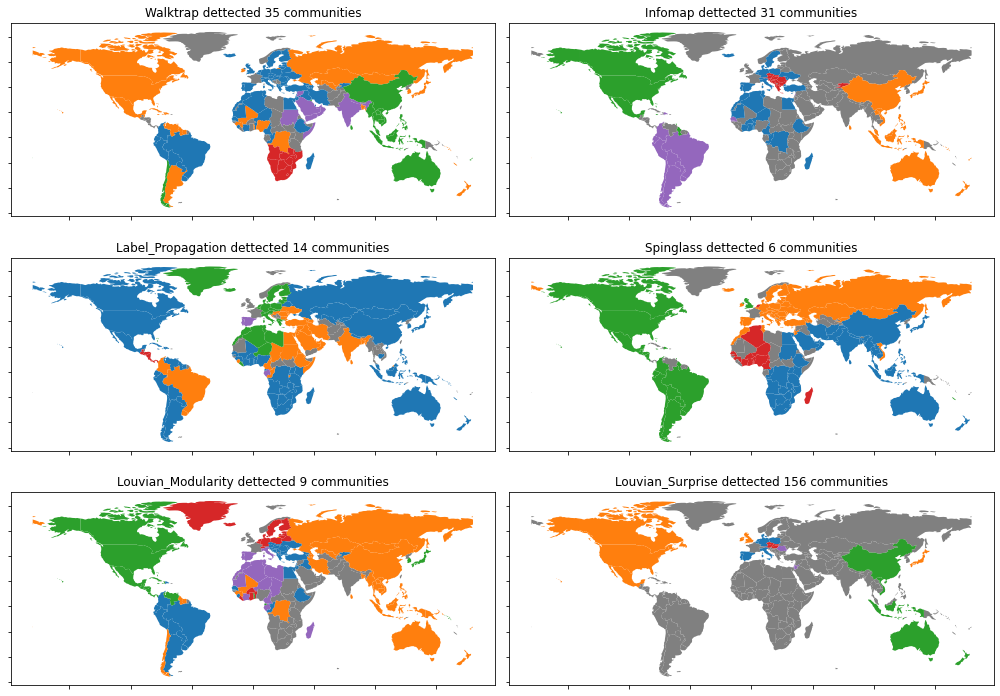

In [23]:
test = get_all_comm2(2015,1)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world.rename(columns={"iso_a3": "Node"}, inplace=True)
world = pd.merge(world, test, on='Node', how='outer')

community_maps_algorithm(world,n=5)

## Distribution of the communities for the different algorithms

In [24]:
def kde(g):
    g[["Walktrap", "Spinglass", "Infomap", "Label_Propagation",
          "Louvian_Modularity", "Louvian_Surprise"]].plot.kde( figsize=(12,8),
                                                fontsize=16,
             xlim=(-1,25),
             grid=True)
    plt.title("Distribution of the communities size",fontsize=20)
    plt.xlabel("Community size",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.savefig('Figures/communities_size_by_algorithm.png')
    plt.legend(fontsize=20)
    plt.show()

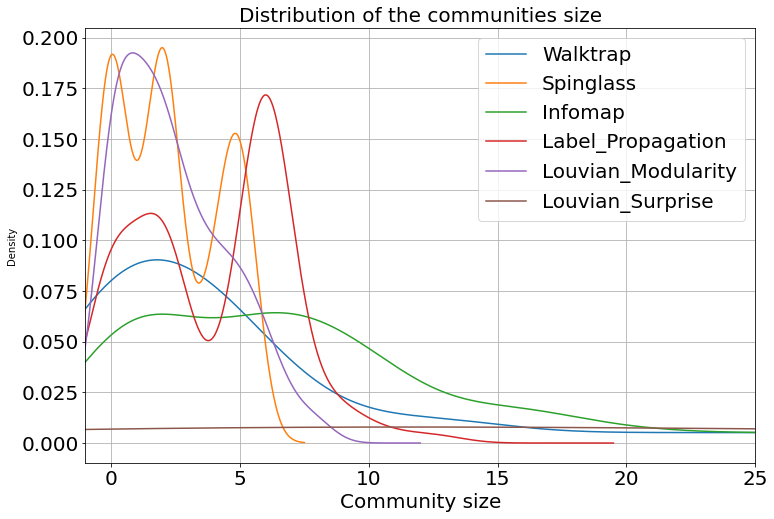

In [25]:
df_total = get_all_comm2(year,commodity)
kde(df_total)

## Evolution of community properties for each algorithm

In [26]:
#Read the written file
df_communities_algorithms = pd.read_csv(fr"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/Hilario/Data/Community/community_algorithms_2001_2020.csv")

In [27]:
def c_algorithms_comparison(df,variable,ylim=55 ):
    fig, axs = plt.subplots(8,3, figsize=(14, 30), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    for i in range(1,24):
        experiment = df_communities_algorithms[df_communities_algorithms["Commodity"]==i].pivot(index="Year",columns="Algorithm",values=variable)
        i-=1
        #world.boundary.plot(ax=axs[i])
        experiment.plot(ylim=(0,ylim),ax=axs[i],legend=False)
        axs[i].set_title(f"Commodity {i+1}")
        axs[i].set_xlabel("Year")
        axs[i].set_ylabel(variable)
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

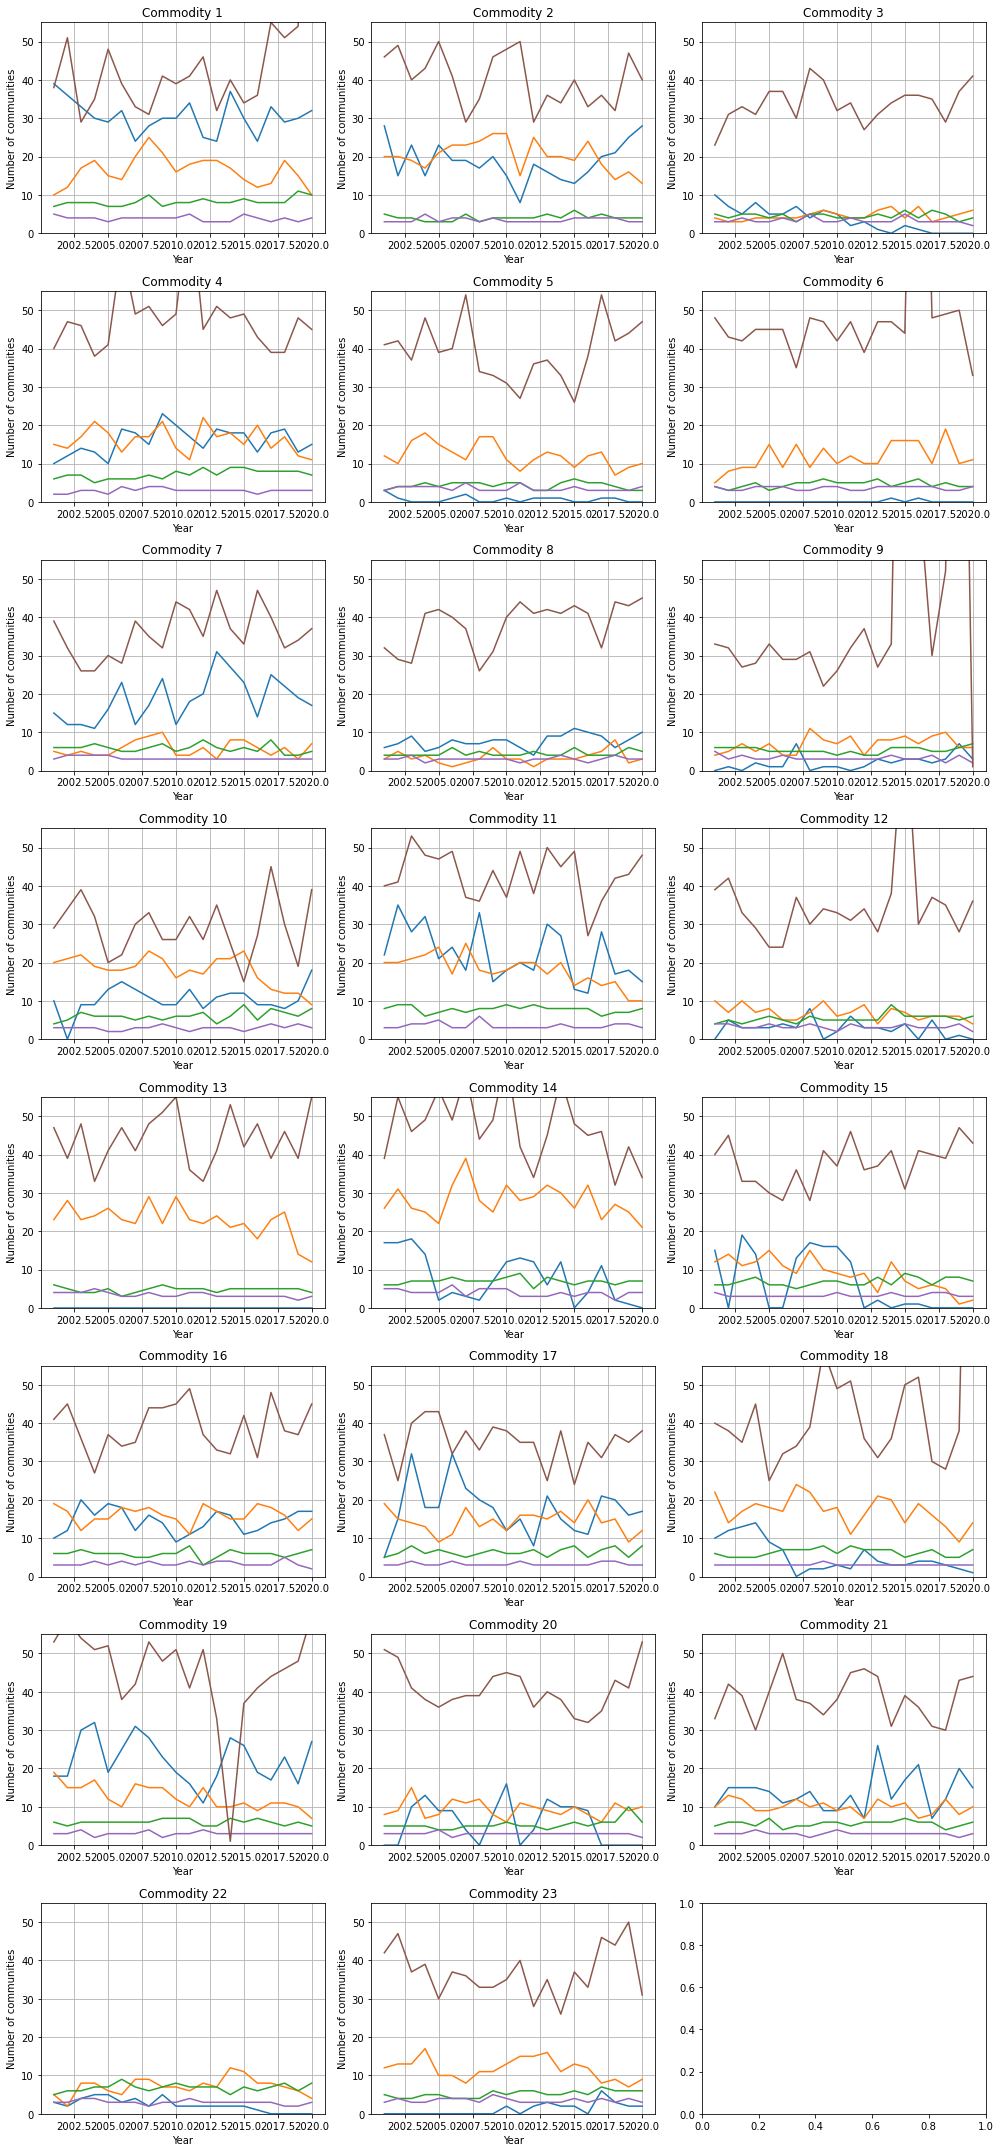

In [28]:
c_algorithms_comparison(df_communities_algorithms,"Number of communities")

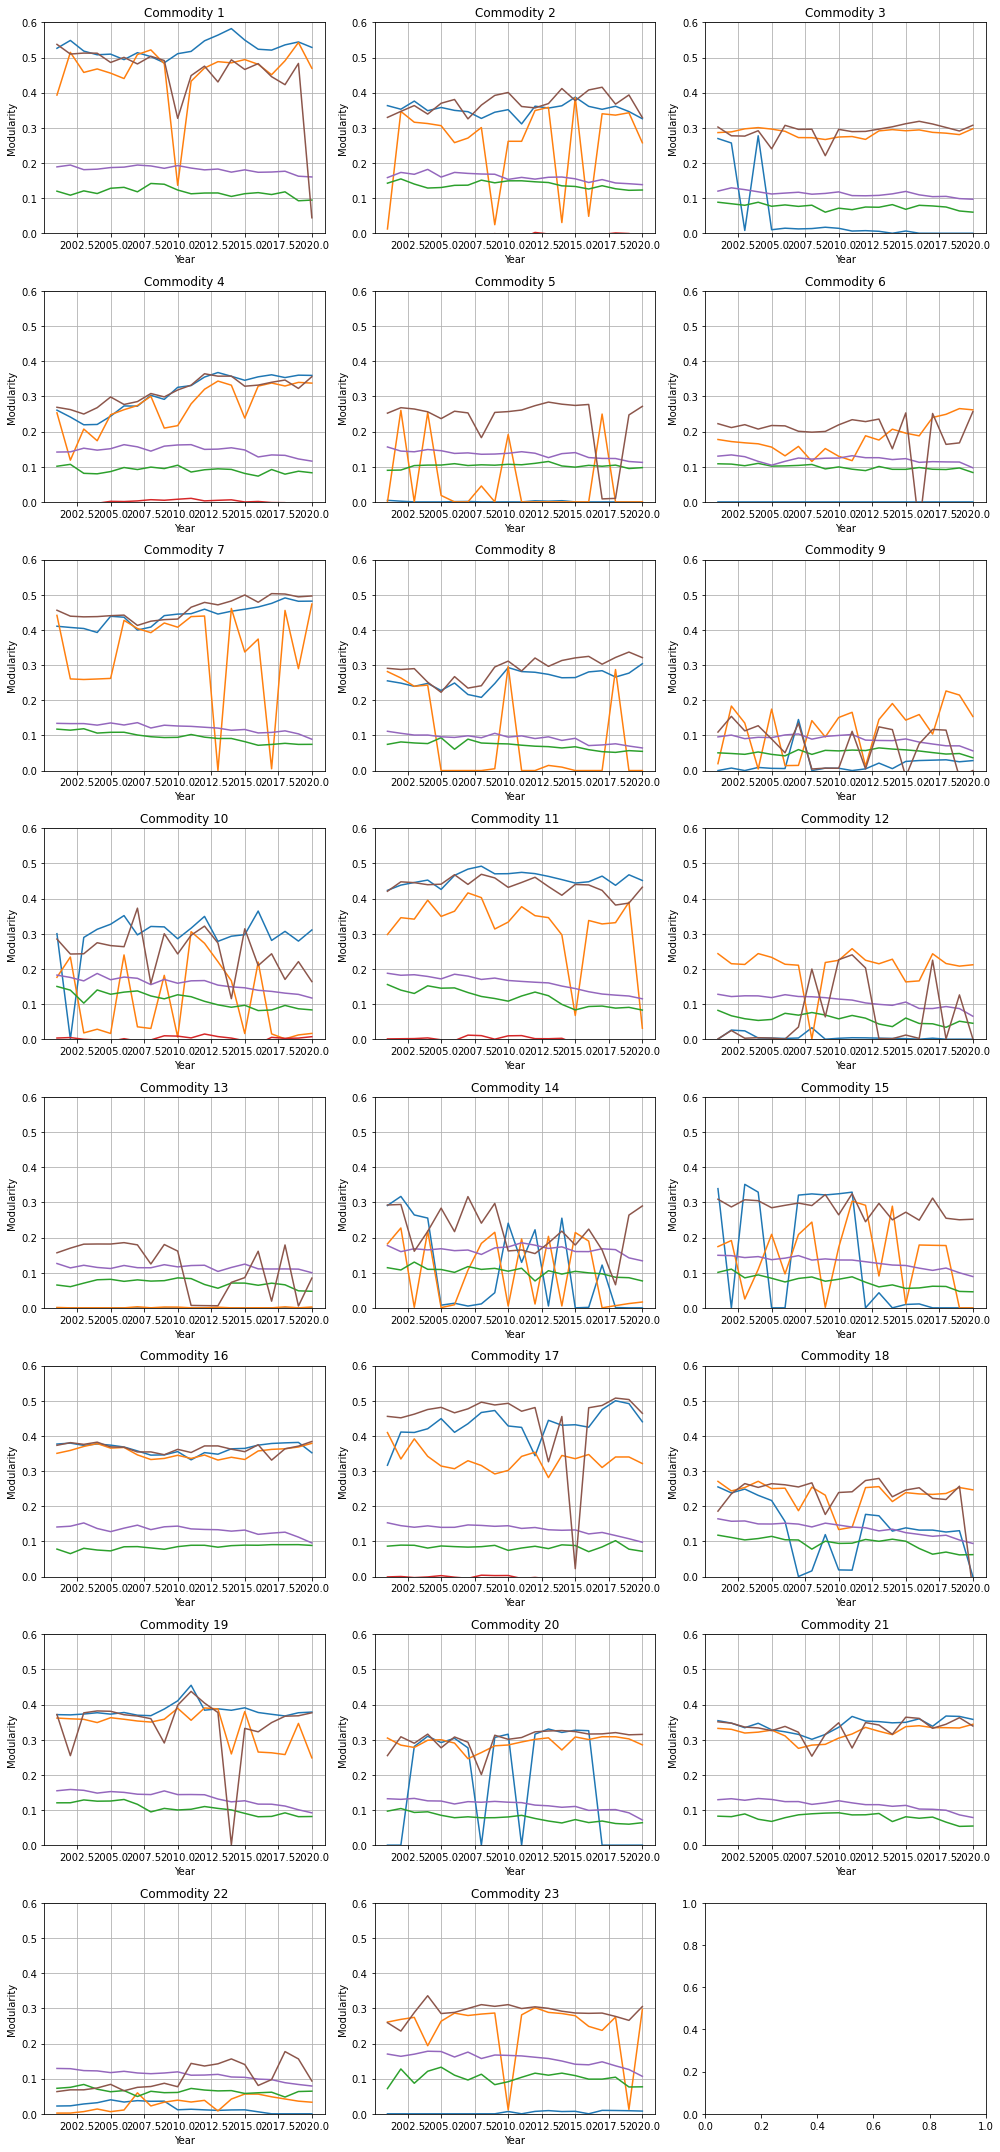

In [29]:
c_algorithms_comparison(df_communities_algorithms,"Modularity",ylim=0.6)

# Communities by commodity

Now we try to identify communities trading the same product.

In [30]:
def get_all_commodities(year,algorithm):
    '''This function get the communities obtained for 
       a specific     year
       and a specific commodity
       for all the algorithms Waltrap, infomap,
       label_propagation, spinglass, Louvian_Modularity, Louvian_surprise'''
    
    '''Be aware that spinglass is applied only to the giant component'''
    df = country_coordinates(fr"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/NS_FP_DATA/countries.csv")
    commodities = [i for i in range(1,24)] 
    i = 3
    for commodity in commodities:
        df_read = pd.read_csv(fr"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/Hilario/Data/Community/{algorithm}_{year}_{commodity}_communities.csv") 
        df = pd.merge(df, df_read, on='Node', how='outer')
        df = df.rename(columns={df.columns[i]: commodity})
        i +=1
    df = df.dropna(subset=commodity, how='all')
    return(df)

In [31]:
def community_maps_commodity(df,n=5):
    fig, axs = plt.subplots(12,2, figsize=(14, 40), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    commodities = [i for i in range(1,24)]
    com_names = ["livestocks","meats","fish&shellfish","dairy","animals_derived","trees&plants","vegetables",
                 "fruits&nuts","coffee&tea","cereals","wheats","oilcrops","gums&resins","vegetable_materials",
                 "oils&fats","meat&fish_derived","sugars","cocoa","wheats","baked_goods","food_preparations",
                 "beverages","foodwaste_industries"]

    #year = [i for i in range(2001,2021)]
    for i in commodities: 
        col= ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

        #This is a list with the code for the biggest communities in order
        biggest_communities = list(world[i].value_counts().to_dict().keys())
        key = biggest_communities[0:n]
        values = col[0:n]
        colors = dict(zip(key, values))
        
        
        country = []
        for j in df[i]:
            if math.isnan(j)==False:
                if j in key:
                    country.append(colors[j])
                else:
                    country.append('grey')
            else:
                country.append('grey')
        df.plot(ax=axs[i-1], color = country)
        axs[i-1].set_title(f'Commodity: {com_names[i-1]}')
        axs[i-1].set_yticklabels([])
        axs[i-1].set_xticklabels([])
    #    axs[i].grid(True)
    plt.tight_layout()
    #plt.savefig('Figures/communities_by_commodity.png')
    plt.show() 

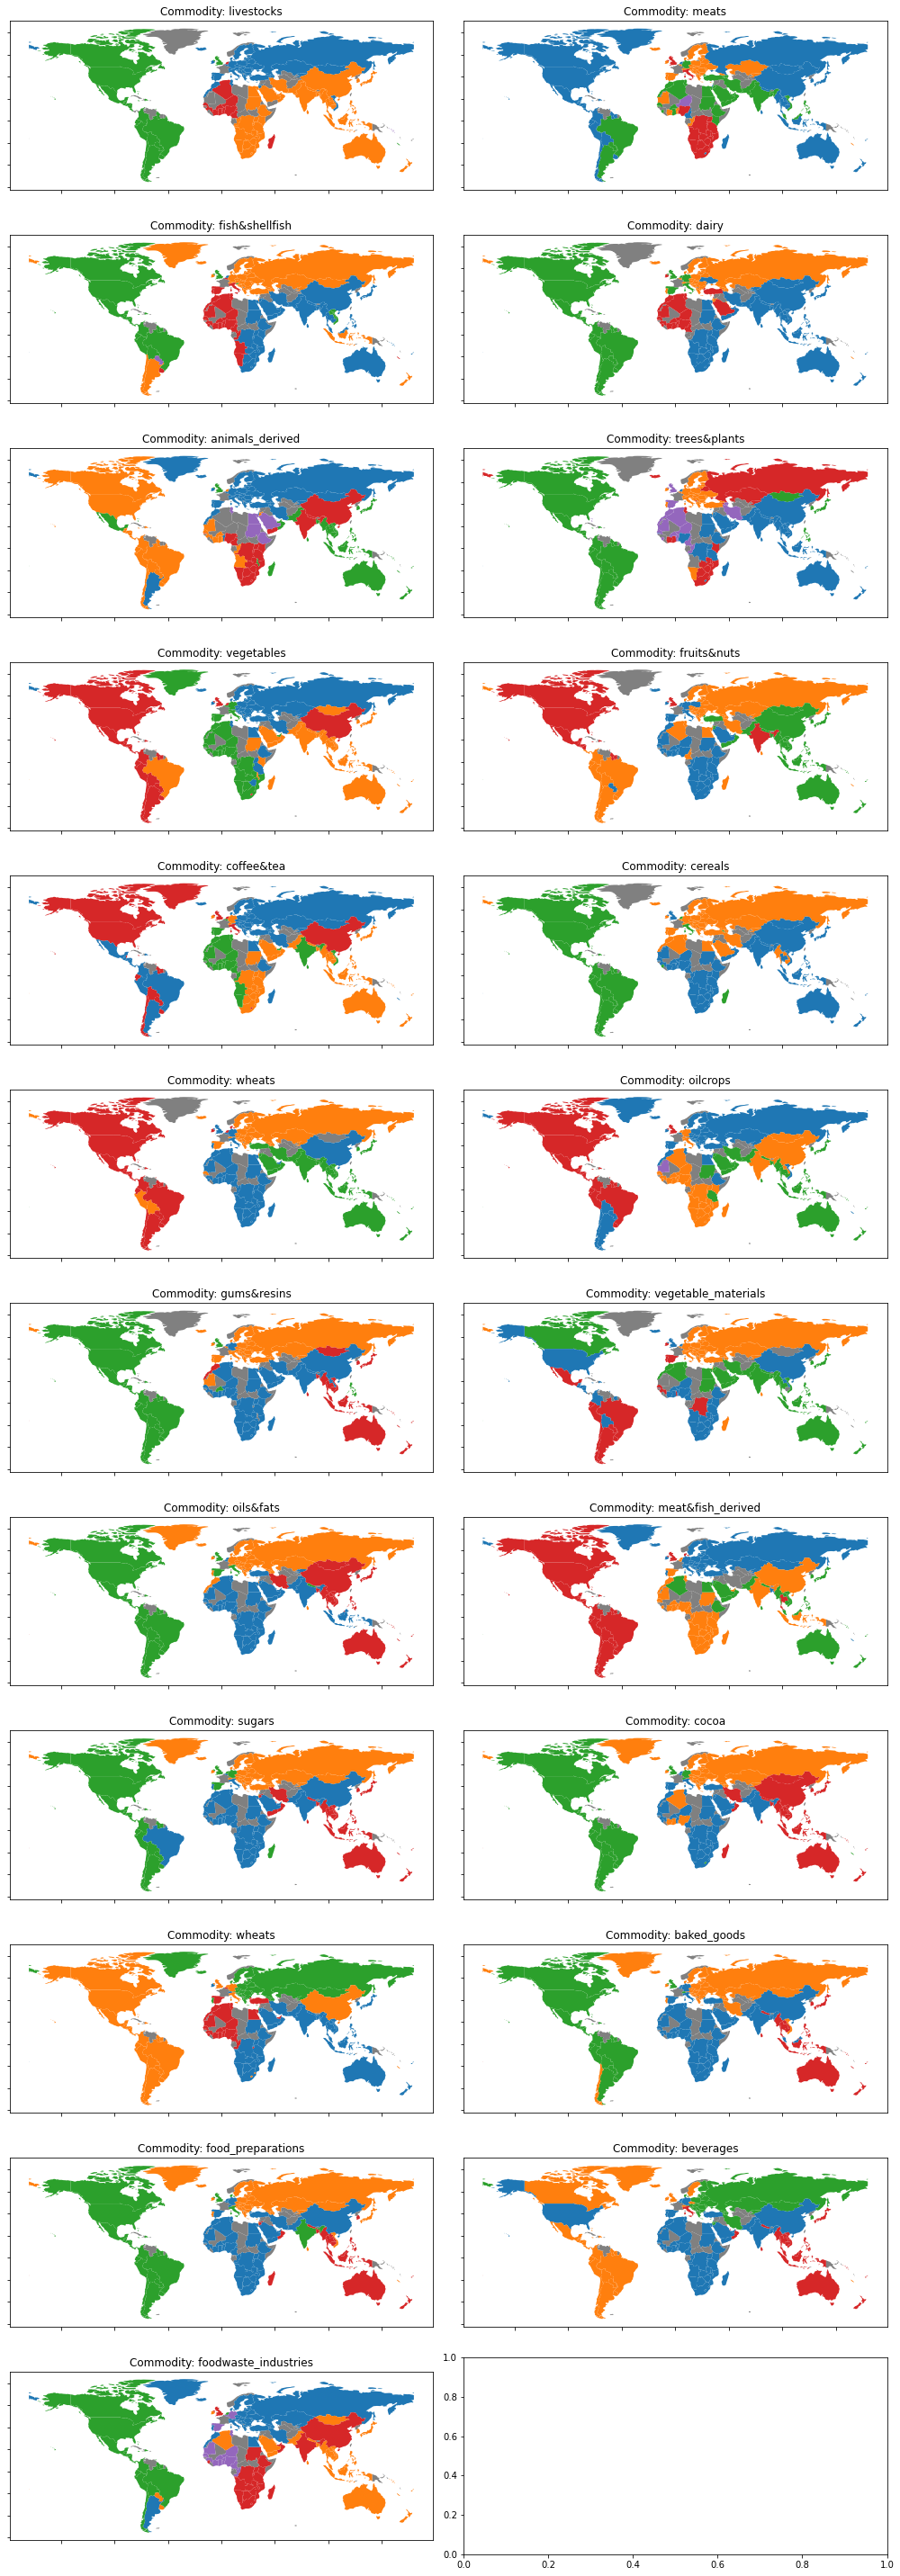

In [32]:
test = get_all_commodities(2015,"Spinglass")
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world.rename(columns={"iso_a3": "Node"}, inplace=True)
world = pd.merge(world, test, on='Node', how='outer')

community_maps_commodity(world,n=5)

# Centrality by community

In [33]:
def centrality_by_community(year,commodity,algorithm):
    directory = fr"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/NS_FP_DATA/final_dataset.csv"
    fields = ['yr','rt3ISO','pt3ISO','cmdCode','TradeValue']

    df = pd.read_csv(directory, skipinitialspace = True, usecols = fields)
    #Filter by commodity and year
    df = df[df['yr']      == year]
    df = df[df['cmdCode'] == commodity]
    #Obtain the country 
    df_community = pd.read_csv(fr"C:\Users\hilar\My Drive\PoD\3rdSemester\Network_science\Network_Science_Project/Hilario/Data/Community/{algorithm}_{year}_{commodity}_communities.csv")
    #Get all the community keys
    com_keys = list(df_community["Community"].unique())
    
    com_betweenness_centrality = []
    n_members_community = []
    for com in com_keys:
        com_members = list(df_community[df_community["Community"]==com]["Node"])
    
        #Now we wanto to keep the nodes belonging to a specific key
        df_com = df[df['rt3ISO'].isin(com_members)]
        df_com = df_com[df_com['pt3ISO'].isin(com_members)]
    
        #Generate the graph
        G = nx.from_pandas_edgelist(df_com,
                             source       = 'rt3ISO',
                             target       = 'pt3ISO',
                             edge_attr    =  'TradeValue',
                             create_using = nx.DiGraph())
    
        #Estimate the mean
        #print(nx.info(G))
        mean = np.mean(list(nx.betweenness_centrality(G, weight = 'TradeValue').values()))
        if math.isnan(mean)==False: 
            com_betweenness_centrality.append(mean)
            n_members_community.append(len(com_members))
            
    plt.bar([i for i in range(1,len(com_betweenness_centrality)+1)],com_betweenness_centrality)
    plt.title(f"{algorithm}",fontsize=15)
    plt.xlabel("Community",fontsize=15)
    plt.ylabel("Average betweenness",fontsize=15)
    #plt.savefig(f'Figures/{algorithm}_degree_by_community.png')
    plt.legend(fontsize=15)
    plt.show()


C:\Users\hilar\anaconda3\envs\geo_env\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hilar\anaconda3\envs\geo_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


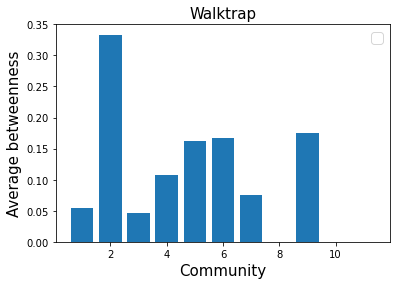

In [34]:
centrality_by_community(2015,1,"Walktrap")